In [ ]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install -q transformers
!pip install -q scikit-learn
!pip install -q pandas
!pip install -q networkx
!pip install -q tqdm
!pip install -q matplotlib


In [ ]:
# setup.py
import os
import random
import numpy as np
import torch

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# embedder.py
from transformers import BertModel, BertTokenizer

class BertEmbedder:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.model = BertModel.from_pretrained("bert-base-uncased").to(device)
        self.model.eval()
        self.dim = 768

    def encode_batch(self, texts):
        inputs = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.pooler_output.cpu()


In [ ]:
#@title "" 📦 Unzip and Extract PHEME Dataset in a Notebook

import os
import tarfile
import bz2
import shutil

def unzip_pheme_in_notebook(pheme_bz2_path, output_dir):
    """
    Decompress .tar.bz2 PHEME dataset and extract it.

    Args:
        pheme_bz2_path (str): Path to 'pheme-rnr-dataset.tar.bz2'
        output_dir (str): Directory where extracted files will be saved
    """
    # Check file format
    if not pheme_bz2_path.endswith('.tar.bz2'):
        raise ValueError("Input file must be a '.tar.bz2' compressed file.")

    tar_path = pheme_bz2_path.replace('.bz2', '')

    # Step 1: Decompress .bz2 to .tar
    print(f"📦 Decompressing {pheme_bz2_path}...")
    with bz2.BZ2File(pheme_bz2_path) as fr, open(tar_path, 'wb') as fw:
        shutil.copyfileobj(fr, fw)
    print(f"✅ Decompressed to {tar_path}")

    # Step 2: Extract .tar
    print(f"📂 Extracting {tar_path} to {output_dir}...")
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(path=output_dir)
    print(f"✅ Extracted to {output_dir}")

    # Step 3: Optional — Clean up intermediate .tar
    os.remove(tar_path)
    print(f"🧹 Removed temporary file {tar_path}")

# Example usage:
pheme_bz2_file = "/mnt/dev/phemernrdataset.tar.bz2"  # CHANGE this to your actual file
output_folder = "/mnt/dev/pheme"              # CHANGE this to your desired output

unzip_pheme_in_notebook(pheme_bz2_file, output_folder)


📦 Decompressing /mnt/dev/phemernrdataset.tar.bz2...
✅ Decompressed to /mnt/dev/phemernrdataset.tar
📂 Extracting /mnt/dev/phemernrdataset.tar to /mnt/dev/pheme...
✅ Extracted to /mnt/dev/pheme
🧹 Removed temporary file /mnt/dev/phemernrdataset.tar


In [ ]:
# model.py
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

'''
class CANSpp(nn.Module):
    def __init__(self, in_dim=768, hidden_dim=1024, out_dim=2):
        super().__init__()
        self.gnn1 = GATConv(in_dim, hidden_dim // 8, heads=8, dropout=0.6)
        self.gnn2 = GATConv(hidden_dim, hidden_dim // 8, heads=8, dropout=0.6)
        self.text_fc = nn.Linear(in_dim - 1, hidden_dim)
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads=8)
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(hidden_dim, out_dim)
        self.cfrnet = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, 1)])

    # ➡️ Indent the forward function to be at the class level
    def forward(self, data, treatment=None):
        text_vec = data.x[:, :768].unsqueeze(1)
        graph_x = data.x
        edge_index = data.edge_index
        batch_size = data.num_graphs

        h = F.relu(self.gnn1(graph_x, edge_index))
        h = self.dropout(h)
        gnn_out = F.relu(self.gnn2(h, edge_index))
        gnn_out = self.dropout(gnn_out)

        root_node = gnn_out[:batch_size].unsqueeze(0)

        text_emb = F.relu(self.text_fc(text_vec.squeeze(1)))
        text_emb = text_emb.view(batch_size, -1, text_emb.shape[-1])

        root_node = root_node.repeat(1, text_emb.shape[1], 1)

        fused, _ = self.attn(text_emb, root_node, root_node)

        # ➡️ Pool across node outputs (mean)
        fused = fused.mean(dim=1)   # (batch_size, hidden_dim)

        logits = self.classifier(fused)


if treatment is not None:
    h = F.relu(self.cfrnet[0](fused))
    cf_out = self.cfrnet[1](h)
    return logits, cf_out


## TM: Corrects inaccuracy where we say we are predicting both Ŷ₀ (no treatment) and Ŷ₁ (treatment), but only returing one counterfactual

        if treatment is not None:
    h = F.relu(self.cfrnet[0](fused))
    y0 = self.cfrnet_y0(h)  # prediction under T=0
    y1 = self.cfrnet_y1(h)  # prediction under T=1 (can be separate heads later)

    return logits, y0, y1
'''

class CANSpp(nn.Module):
    def __init__(self, in_dim=768, hidden_dim=1024, out_dim=2):
        super().__init__()

        # Graph Neural Network Layers
        self.gnn1 = GATConv(in_dim, hidden_dim // 8, heads=8, dropout=0.6)
        self.gnn2 = GATConv(hidden_dim, hidden_dim // 8, heads=8, dropout=0.6)

        # Text processing
        self.text_fc = nn.Linear(in_dim - 1, hidden_dim)

        # Fusion layer
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads=8)
        self.dropout = nn.Dropout(p=0.3)

        # Final classifier (for supervised prediction)
        self.classifier = nn.Linear(hidden_dim, out_dim)

        # Causal layers: shared base, separate heads for Y0 and Y1
        self.cfr_shared = nn.Linear(hidden_dim, hidden_dim)
        self.cfr_y0 = nn.Linear(hidden_dim, 1)
        self.cfr_y1 = nn.Linear(hidden_dim, 1)

    def forward(self, data, treatment=None):
        text_vec = data.x[:, :768].unsqueeze(1)
        graph_x = data.x
        edge_index = data.edge_index
        batch_size = data.num_graphs

        # GNN encoding
        h = F.relu(self.gnn1(graph_x, edge_index))
        h = self.dropout(h)
        gnn_out = F.relu(self.gnn2(h, edge_index))
        gnn_out = self.dropout(gnn_out)
        root_node = gnn_out[:batch_size].unsqueeze(0)

        # Text encoding and fusion
        text_emb = F.relu(self.text_fc(text_vec.squeeze(1)))
        text_emb = text_emb.view(batch_size, -1, text_emb.shape[-1])
        root_node = root_node.repeat(1, text_emb.shape[1], 1)
        fused, _ = self.attn(text_emb, root_node, root_node)
        fused = fused.mean(dim=1)  # (batch_size, hidden_dim)

        logits = self.classifier(fused)

        if treatment is not None:
            h_cfr = F.relu(self.cfr_shared(fused))
            y0 = self.cfr_y0(h_cfr)
            y1 = self.cfr_y1(h_cfr)
            return logits, y0, y1

        return logits


In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

# TM added to update eval logic to leverage model ability to return both counterfactuals
def compute_ite_ate(model, data_loader, device='cuda'):
    """
    Computes Individual Treatment Effects (ITE) and Average Treatment Effect (ATE)
    using the model's counterfactual outputs y0 and y1.

    Also returns per-class ATE breakdowns.
    """
    model.eval()
    ite_list = []

    # TM: Collect per-class ITEs
    ite_treated = []  # For T=1 (rumor)
    ite_control = []  # For T=0 (non-rumor)

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            treatment = data.y

            # Forward pass with treatment labels
            _, y0, y1 = model(data, treatment=treatment)

            # Compute ITE = Ŷ₁ - Ŷ₀
            ite = (y1 - y0).squeeze().cpu().tolist()

            # TM fix for float case (batch size = 1)
            if isinstance(ite, list):
                ite_list.extend(ite)
                for i, t in enumerate(treatment.cpu().tolist()):
                    if t == 1:
                        ite_treated.append(ite[i])
                    else:
                        ite_control.append(ite[i])
            else:
                ite_list.append(ite)
                if treatment.item() == 1:
                    ite_treated.append(ite)
                else:
                    ite_control.append(ite)

    ate = sum(ite_list) / len(ite_list) if ite_list else 0.0
    ate_treated = sum(ite_treated) / len(ite_treated) if ite_treated else 0.0
    ate_control = sum(ite_control) / len(ite_control) if ite_control else 0.0

    # TM: Print breakdown for each class
    print(f"✅ Average Treatment Effect (ATE): {ate:.4f}")
    print(f"   ATE (Rumor / Treated):     {ate_treated:.4f}")
    print(f"   ATE (Non-Rumor / Control): {ate_control:.4f}")

    return ite_list, ate


# TM helper function to compute linear MMD loss between treated and control groups
def compute_mmd_loss(z, treatment):
    """
    Compute linear MMD loss between treated and control groups.

    Args:
        z (Tensor): Latent representations (batch_size, hidden_dim)
        treatment (Tensor): Binary treatment vector (batch_size,)

    Returns:
        mmd_loss (Tensor): Scalar MMD loss
    """
    treated = z[treatment == 1]
    control = z[treatment == 0]

    if treated.size(0) == 0 or control.size(0) == 0:
        return torch.tensor(0.0, device=z.device)

    # TM: MMD loss is the squared L2 norm of the difference between group means
    mmd_loss = torch.norm(treated.mean(dim=0) - control.mean(dim=0)) ** 2
    return mmd_loss

# TM helper function to compute intervention consistency loss
def compute_intervene_loss(y_hat, y0, y1, treatment):
    """
    Enforces consistency between the model's factual output and a mixture
    of counterfactual predictions based on the treatment value.

    Args:
        y_hat (Tensor): Model's factual logits output (batch_size, num_classes)
        y0 (Tensor): Predicted outcome under control (T=0)
        y1 (Tensor): Predicted outcome under treatment (T=1)
        treatment (Tensor): Binary treatment vector (batch_size,)

    Returns:
        intervene_loss (Tensor): Scalar MSE loss
    """
    t = treatment.float().unsqueeze(1)  # shape: (batch_size, 1)
    mixed = t * y1 + (1 - t) * y0
    intervene_loss = torch.mean((y_hat - mixed) ** 2)
    return intervene_loss


def train_model(model, train_loader, val_loader, epochs=50, lr=1e-4, patience=5, device='cuda'):
    model = model.to(device)
    class_weights = torch.tensor([2.0, 1.0], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    best_f1, patience_counter = 0.0, 0
    train_losses, val_losses, val_f1s = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()

            treatment = data.y  # Binary treatment: 0 = non-rumor, 1 = rumor
            logits, y0, y1 = model(data, treatment=treatment)

            # Compute classification loss
            classification_loss = criterion(logits, treatment)

            # TM causal regularization losses
            mmd_loss = compute_mmd_loss(logits, treatment)  # TM assumes this is defined elsewhere
            intervene_loss = compute_intervene_loss(logits, y0, y1, treatment)  # TM assumes this is defined elsewhere

            # Total loss with coefficients
            λ_mmd = 1.0
            λ_int = 1.0
            loss = classification_loss + λ_mmd * mmd_loss + λ_int * intervene_loss

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        y_true, y_pred = [], []
        val_loss = 0.0

        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data)
                loss = criterion(out, data.y)
                val_loss += loss.item()
                preds = out.argmax(dim=1)
                y_true.extend(data.y.cpu().tolist())
                y_pred.extend(preds.cpu().tolist())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        macro_f1 = f1_score(y_true, y_pred, average='macro')
        val_f1s.append(macro_f1)

        # TM loss print including breakdown
        print(f"Epoch {epoch+1}, Batch Loss: {loss.item():.4f} | Cls: {classification_loss.item():.4f} | MMD: {mmd_loss.item():.4f} | INT: {intervene_loss.item():.4f}")
        scheduler.step(macro_f1)

        if macro_f1 > best_f1:
            best_f1 = macro_f1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model saved with F1={best_f1:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best model and evaluate causal outputs
    model.load_state_dict(torch.load('best_model.pt'))

    # TM Evaluate counterfactuals for interpretability
    ite_list, ate = compute_ite_ate(model, val_loader, device=device)
    print(f"✅ Average Treatment Effect (ATE): {ate:.4f}")

    return model, train_losses, val_losses, val_f1s

In [ ]:
#@title "unzip file"

import zipfile
import os

zip_path = "/mnt/deviance/twitter15.zip"  # Adjust to your ZIP file location
extract_dir = "/mnt/deviance/twitter15"  # Base directory to extract into

# Unzip the file
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)
print(f"Unzipped {zip_path} to {extract_dir}")

Unzipped /mnt/deviance/twitter15.zip to /mnt/deviance/twitter15


In [ ]:
import os
import json
import random
import torch
import networkx as nx
from torch_geometric.data import Data
from tqdm import tqdm
from datetime import datetime
import pandas as pd

def load_pheme_ultimate_loader(pheme_root, embedder):
    """
    Ultimate PHEME loader: handles source-tweet/, reactions/, or flat .json directly.
    """
    all_graphs = []
    label_map = {
        'rumours': 1,
        'non-rumours': 0
    }

    events = os.listdir(pheme_root)
    print(f"📂 Found {len(events)} events: {events}")

    for event in events:
        event_path = os.path.join(pheme_root, event)
        if not os.path.isdir(event_path):
            continue

        for rumour_type in ['rumours', 'non-rumours']:
            rumour_path = os.path.join(event_path, rumour_type)
            if not os.path.isdir(rumour_path):
                continue

            threads = os.listdir(rumour_path)
            print(f"🔍 Event: {event}, Type: {rumour_type} - Found {len(threads)} threads.")

            for thread_id in tqdm(threads, desc=f"Loading {event}/{rumour_type}"):
                thread_path = os.path.join(rumour_path, thread_id)
                if not os.path.isdir(thread_path):
                    continue

                tweets = []

                # CASE 1: source-tweet/ + reactions/
                source_dir = os.path.join(thread_path, 'source-tweet')
                reactions_dir = os.path.join(thread_path, 'reactions')

                if os.path.isdir(source_dir):
                    # Load source tweet
                    for file_name in os.listdir(source_dir):
                        if not file_name.endswith('.json'):
                            continue
                        tweet_path = os.path.join(source_dir, file_name)
                        tweet = load_json_safe(tweet_path, file_name)
                        tweets.append(tweet)

                if os.path.isdir(reactions_dir):
                    # Load reaction tweets
                    for file_name in os.listdir(reactions_dir):
                        if not file_name.endswith('.json'):
                            continue
                        tweet_path = os.path.join(reactions_dir, file_name)
                        tweet = load_json_safe(tweet_path, file_name)
                        tweets.append(tweet)

                # CASE 2: Flat .json files directly inside thread
                if not tweets:
                    for file_name in os.listdir(thread_path):
                        if not file_name.endswith('.json'):
                            continue
                        tweet_path = os.path.join(thread_path, file_name)
                        tweet = load_json_safe(tweet_path, file_name)
                        tweets.append(tweet)

                if len(tweets) == 0:
                    continue

                label = label_map.get(rumour_type, 0)

                graph_data = build_graph_from_flat_thread(tweets, thread_id, label, embedder)
                if graph_data:
                    all_graphs.append(graph_data)

    print(f"✅ Total graphs loaded: {len(all_graphs)}")

    rumor_graphs = [g for g in all_graphs if g.y.item() == 1]
    non_rumor_graphs = [g for g in all_graphs if g.y.item() == 0]
    print(f"📊 Before balancing: {len(rumor_graphs)} Rumor graphs, {len(non_rumor_graphs)} Non-Rumor graphs.")

    # Balance
    min_count = min(len(rumor_graphs), len(non_rumor_graphs))
    rumor_graphs = random.sample(rumor_graphs, min_count)
    non_rumor_graphs = random.sample(non_rumor_graphs, min_count)
    all_graphs = rumor_graphs + non_rumor_graphs
    random.shuffle(all_graphs)

    df = create_dataframe(all_graphs)
    return all_graphs, df

def load_json_safe(path, file_name):
    """
    Safely load JSON file, fallback to synthetic if needed.
    """
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except Exception:
        # Create synthetic if tweet missing
        tweet_id = file_name.replace('.json', '')
        return {
            'id': tweet_id,
            'text': f"Synthetic Tweet {tweet_id}",
            'created_at': None,
            'in_reply_to_status_id': None
        }

def build_graph_from_flat_thread(tweets, thread_id, label, embedder):
    """
    Build a graph from loaded tweets.
    """
    G = nx.DiGraph()

    tweet_dict = {str(tweet['id']): tweet for tweet in tweets}

    # Build nodes
    for tweet_id, tweet in tweet_dict.items():
        text = tweet.get('text', f"Tweet {tweet_id}")
        created_at = parse_created_at(tweet.get('created_at'))
        G.add_node(tweet_id, text=text, timestamp=created_at)

    # Build edges based on reply relationships
    for tweet_id, tweet in tweet_dict.items():
        in_reply_to_status_id = str(tweet.get('in_reply_to_status_id', ''))
        if in_reply_to_status_id and in_reply_to_status_id in tweet_dict:
            G.add_edge(in_reply_to_status_id, tweet_id)

    if not G.nodes():
        return None

    # Root node
    root_id = thread_id
    if root_id not in G.nodes():
        root_id = list(G.nodes())[0]

    node_order = list(G.nodes())
    texts = [G.nodes[n]['text'] for n in node_order]
    ts = [G.nodes[n]['timestamp'] for n in node_order]
    timestamps = torch.tensor(ts, dtype=torch.float)
    timestamps = (timestamps - timestamps.min()) / (timestamps.max() - timestamps.min() + 1e-6)
    timestamps = timestamps.unsqueeze(1)

    x = torch.cat([embedder.encode_batch(texts), timestamps], dim=1)

    # Check if there are edges before creating edge_index
    if G.edges():
        edge_index = torch.tensor([[node_order.index(u), node_order.index(v)] for u, v in G.edges()], dtype=torch.long).t().contiguous()
    else:
        # If no edges, create a dummy edge_index with shape [2, 0]
        edge_index = torch.empty((2, 0), dtype=torch.long)

    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y, thread_id=root_id)

def parse_created_at(created_at_str):
    """
    Parse Twitter's created_at format safely.
    """
    if created_at_str:
        try:
            created_at_dt = datetime.strptime(created_at_str, '%a %b %d %H:%M:%S %z %Y')
            return created_at_dt.timestamp()
        except Exception:
            return 0.0
    else:
        return 0.0

def create_dataframe(all_graphs):
    df_data = []
    for data in all_graphs:
        thread_id = data.thread_id
        label = data.y.item()
        df_data.append({'thread_id': thread_id, 'type': 'source', 'text': data.x[0], 'label': label})
        for i in range(1, data.x.shape[0]):
            df_data.append({'thread_id': thread_id, 'type': 'reply', 'text': data.x[i], 'label': label})
    return pd.DataFrame(df_data)


In [ ]:
# main.py
import os
import torch
from torch_geometric.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


pheme_root = "/mnt/dev/pheme/pheme-rnr-dataset"
embedder = BertEmbedder()  # Your existing BERT embedder

graph_dataset, df = load_pheme_ultimate_loader(pheme_root, embedder)




📂 Found 6 events: ['ottawashooting', 'germanwings-crash', 'sydneysiege', 'charliehebdo', 'README', 'ferguson']
🔍 Event: ottawashooting, Type: rumours - Found 470 threads.


Loading ottawashooting/rumours: 100%|██████████| 470/470 [00:19<00:00, 24.44it/s]


🔍 Event: ottawashooting, Type: non-rumours - Found 420 threads.


Loading ottawashooting/non-rumours: 100%|██████████| 420/420 [00:17<00:00, 23.42it/s]


🔍 Event: germanwings-crash, Type: rumours - Found 238 threads.


Loading germanwings-crash/rumours: 100%|██████████| 238/238 [00:08<00:00, 28.75it/s]


🔍 Event: germanwings-crash, Type: non-rumours - Found 231 threads.


Loading germanwings-crash/non-rumours: 100%|██████████| 231/231 [00:07<00:00, 31.34it/s]


🔍 Event: sydneysiege, Type: rumours - Found 522 threads.


Loading sydneysiege/rumours: 100%|██████████| 522/522 [00:27<00:00, 18.88it/s]


🔍 Event: sydneysiege, Type: non-rumours - Found 699 threads.


Loading sydneysiege/non-rumours: 100%|██████████| 699/699 [00:47<00:00, 14.74it/s]


🔍 Event: charliehebdo, Type: rumours - Found 458 threads.


Loading charliehebdo/rumours: 100%|██████████| 458/458 [00:24<00:00, 19.01it/s]


🔍 Event: charliehebdo, Type: non-rumours - Found 1621 threads.


Loading charliehebdo/non-rumours: 100%|██████████| 1621/1621 [01:42<00:00, 15.81it/s]


🔍 Event: ferguson, Type: rumours - Found 284 threads.


Loading ferguson/rumours: 100%|██████████| 284/284 [00:19<00:00, 14.75it/s]


🔍 Event: ferguson, Type: non-rumours - Found 859 threads.


Loading ferguson/non-rumours: 100%|██████████| 859/859 [00:54<00:00, 15.73it/s]


✅ Total graphs loaded: 5802
📊 Before balancing: 1972 Rumor graphs, 3830 Non-Rumor graphs.


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Train graphs: 2760, Val graphs: 592, Test graphs: 592
Epoch 1, Batch Loss: 0.7152 | Cls: 0.6930 | MMD: 0.0000 | INT: 0.0000
New best model saved with F1=0.3408
Epoch 2, Batch Loss: 0.6864 | Cls: 0.6970 | MMD: 0.0000 | INT: 0.0000
Epoch 3, Batch Loss: 0.6906 | Cls: 0.6906 | MMD: 0.0000 | INT: 0.0000
New best model saved with F1=0.3924
Epoch 4, Batch Loss: 0.6903 | Cls: 0.6966 | MMD: 0.0000 | INT: 0.0000
Epoch 5, Batch Loss: 0.6821 | Cls: 0.7046 | MMD: 0.0000 | INT: 0.0001
Epoch 6, Batch Loss: 0.7012 | Cls: 0.6944 | MMD: 0.0000 | INT: 0.0000
Epoch 7, Batch Loss: 0.7009 | Cls: 0.6886 | MMD: 0.0000 | INT: 0.0000
New best model saved with F1=0.5060
Epoch 8, Batch Loss: 0.6908 | Cls: 0.6853 | MMD: 0.0000 | INT: 0.0001
New best model saved with F1=0.6116
Epoch 9, Batch Loss: 0.7054 | Cls: 0.6521 | MMD: 0.0000 | INT: 0.0018
New best model saved with F1=0.6293
Epoch 10, Batch Loss: 0.6834 | Cls: 0.6832 | MMD: 0.0000 | INT: 0.0001
Epoch 11, Batch Loss: 0.6850 | Cls: 0.6861 | MMD: 0.0000 | INT: 0

<ipython-input-52-8ad610415cb5>:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


✅ Average Treatment Effect (ATE): 0.0001
   ATE (Rumor / Treated):     0.0012
   ATE (Non-Rumor / Control): -0.0009
✅ Average Treatment Effect (ATE): 0.0001


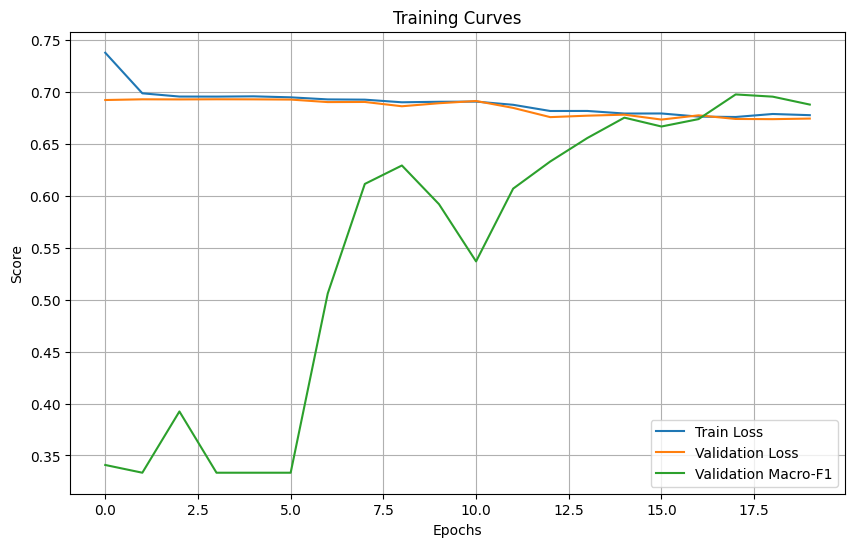


Final Test Set Classification Report:
              precision    recall  f1-score   support

   Non-Rumor       0.74      0.70      0.72       296
       Rumor       0.71      0.75      0.73       296

    accuracy                           0.72       592
   macro avg       0.73      0.72      0.72       592
weighted avg       0.73      0.72      0.72       592

✅ Execution Completed.


In [ ]:
# Split: 70% Train, 15% Val, 15% Test
from sklearn.model_selection import train_test_split

train_graphs, temp_graphs = train_test_split(
    graph_dataset, test_size=0.3, random_state=42, stratify=[g.y.item() for g in graph_dataset]
)
val_graphs, test_graphs = train_test_split(
    temp_graphs, test_size=0.5, random_state=42, stratify=[g.y.item() for g in temp_graphs]
)

train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=1)
test_loader = DataLoader(test_graphs, batch_size=1)

print(f"Train graphs: {len(train_graphs)}, Val graphs: {len(val_graphs)}, Test graphs: {len(test_graphs)}")

# 3. Initialize Model
model = CANSpp(in_dim=embedder.dim + 1)  # BERT + timestamp

# 4. Train Model
trained_model, train_losses, val_losses, val_f1s = train_model(
    model, train_loader, val_loader,
    epochs=20, lr=1e-4, patience=5, device=device
)

# 5. Plot Training Curves
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(val_f1s, label='Validation Macro-F1')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Training Curves')
plt.legend()
plt.grid(True)
plt.show()

# 6. Final Test Evaluation
trained_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = trained_model(batch)
        preds = out.argmax(dim=1)
        y_true.extend(batch.y.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

print("\nFinal Test Set Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Rumor', 'Rumor'], zero_division=0))

print("✅ Execution Completed.")
